## This notebook will help you train a latent Point-Cloud GAN.

(Assumes latent_3d_points is in the PYTHONPATH and that a trained AE model exists)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
# %matplotlib notebook

In [2]:
import sys
sys.path.insert(0, '/home/gy46/')

In [3]:
import numpy as np
import os.path as osp
import matplotlib.pylab as plt

from latent_3d_points.src.point_net_ae import PointNetAutoEncoder
from latent_3d_points.src.autoencoder import Configuration as Conf
from latent_3d_points.src.neural_net import MODEL_SAVER_ID

from latent_3d_points.src.in_out import snc_category_to_synth_id, create_dir, PointCloudDataSet, \
                                        load_all_point_clouds_under_folder

from latent_3d_points.src.general_utils import plot_3d_point_cloud
from latent_3d_points.src.tf_utils import reset_tf_graph

from latent_3d_points.src.vanilla_gan import Vanilla_GAN
from latent_3d_points.src.w_gan_gp import W_GAN_GP
from latent_3d_points.src.generators_discriminators import latent_code_discriminator_two_layers,\
latent_code_generator_two_layers

Specify where the raw point-clouds and the pre-trained AE are.

In [4]:
# Top-dir of where point-clouds are stored.
# top_in_dir = '../data/shape_net_core_uniform_samples_2048/'    
top_in_dir = '../data/ShapeNetV1PCOutput/' # Top-dir of where point-clouds are stored.

# ae_configuration = '../data/single_class_ae/configuration'


In [5]:
# Where to save GANs check-points etc.
top_out_dir = '../data/'

ae_epoch = 500           # Epoch of AE to load.
bneck_size = 128         # Bottleneck-size of the AE
n_pc_points = 2048       # Number of points per model.

# class_name = 'chair'
class_name = 'airplane'
experiment_name = 'latent_gan_with_chamfer_ae_%s'%(class_name)
# experiment_name = 'latent_gan_with_emd_ae_%s'%(class_name)
ae_configuration = '../data/chamfer_ae_%s/configuration'%class_name
# ae_configuration = '../data/emd_ae_%s/configuration'%class_name

In [6]:
# Load point-clouds.
syn_id = snc_category_to_synth_id()[class_name]
class_dir = osp.join(top_in_dir , syn_id, 'train')
# all_pc_data = load_all_point_clouds_under_folder(class_dir, n_threads=8, file_ending='.ply', verbose=True)
all_pc_data = load_all_point_clouds_under_folder(
    class_dir, n_threads=8, file_ending='.npy', max_num_points=2048, verbose=True)
print 'Shape of DATA =', all_pc_data.point_clouds.shape

2832 pclouds were loaded. They belong in 1 shape-classes.
Shape of DATA = (2832, 2048, 3)


In [7]:
# Load pre-trained AE
reset_tf_graph()
ae_conf = Conf.load(ae_configuration)
ae_conf.encoder_args['verbose'] = False
ae_conf.decoder_args['verbose'] = False
ae = PointNetAutoEncoder(ae_conf.experiment_name, ae_conf)
ae.restore_model(ae_conf.train_dir, ae_epoch, verbose=True)

INFO:tensorflow:Restoring parameters from ../data/chamfer_ae_airplane/models.ckpt-500
Model restored in epoch 500.


In [8]:
# Use AE to convert raw pointclouds to latent codes.
latent_codes = ae.get_latent_codes(all_pc_data.point_clouds)
latent_data = PointCloudDataSet(latent_codes)
print 'Shape of DATA =', latent_data.point_clouds.shape

Shape of DATA = (2832, 128)


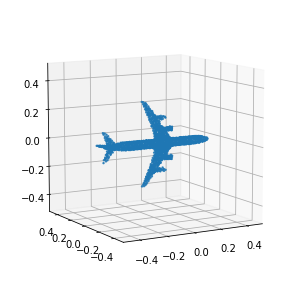

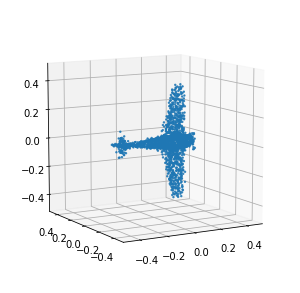

In [9]:
# Check the decoded AE latent-codes look descent.
L = ae.decode(latent_codes)
i = 0
plot_3d_point_cloud(L[i][:, 0], L[i][:, 1], L[i][:, 2], in_u_sphere=True);
i = 20
plot_3d_point_cloud(L[i][:, 0], L[i][:, 1], L[i][:, 2], in_u_sphere=True);

In [10]:
# Set GAN parameters.

use_wgan = True     # Wasserstein with gradient penalty, or not?
n_epochs = 500        # Epochs to train.

plot_train_curve = True
save_gan_model = False
saver_step = np.hstack([np.array([1, 5, 10]), np.arange(50, n_epochs + 1, 250)])

# If true, every 'saver_step' epochs we produce & save synthetic pointclouds.
save_synthetic_samples = True
# How many synthetic samples to produce at each save step.
n_syn_samples = latent_data.num_examples

# Optimization parameters
init_lr = 0.0001
batch_size = 50
noise_params = {'mu':0, 'sigma': 0.2}
noise_dim = bneck_size
beta = 0.5 # ADAM's momentum.

n_out = [bneck_size] # Dimensionality of generated samples.

if save_synthetic_samples:
    synthetic_data_out_dir = osp.join(top_out_dir, 'OUT/synthetic_samples/', experiment_name)
    create_dir(synthetic_data_out_dir)

if save_gan_model:
    train_dir = osp.join(top_out_dir, 'OUT/latent_gan', experiment_name)
    create_dir(train_dir)

In [11]:
reset_tf_graph()

if use_wgan:
    lam = 10 # lambda of W-GAN-GP
    gan = W_GAN_GP(experiment_name, init_lr, lam, n_out, noise_dim, \
                  latent_code_discriminator_two_layers, 
                  latent_code_generator_two_layers,\
                  beta=beta)
else:    
    gan = Vanilla_GAN(experiment_name, init_lr, n_out, noise_dim,
                     latent_code_discriminator_two_layers, latent_code_generator_two_layers,
                     beta=beta)

In [12]:
accum_syn_data = []
train_stats = []

1 (-4.199208974838257, -0.19915071305480192)


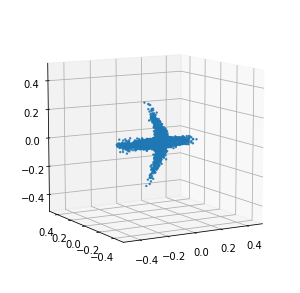

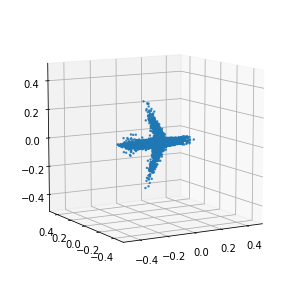

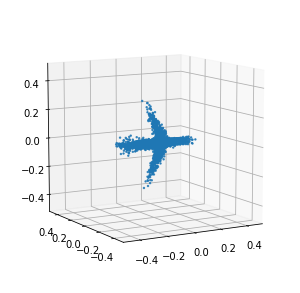

2 (-10.942486069419168, -0.711367970163172)
3 (-11.854628198797053, -1.073035012591969)
4 (-11.826210195367986, -1.2494198950854214)
5 (-11.673432957042348, -1.396395910869945)


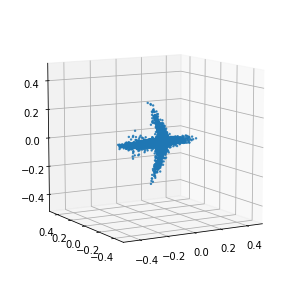

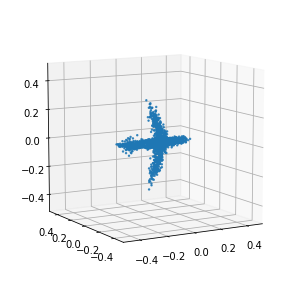

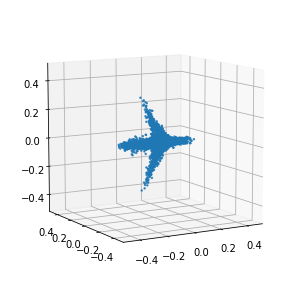

6 (-11.543112789500844, -1.586955558169972)
7 (-11.399331543662331, -1.7594221180135554)
8 (-11.253712723471901, -1.955402439290827)
9 (-11.072012329101563, -2.1593383225527676)
10 (-10.881721496582031, -2.3515877940438012)


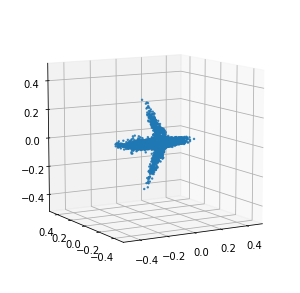

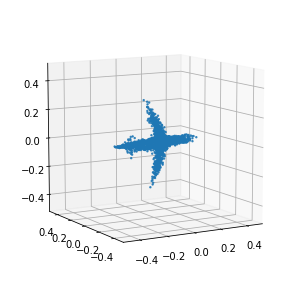

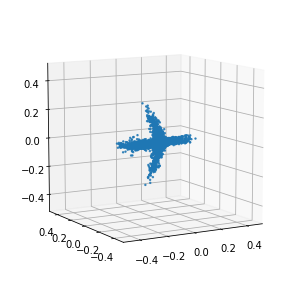

11 (-10.67980074449019, -2.58512282371521)
12 (-10.454902076721192, -2.7894020080566406)
13 (-10.232051727988503, -3.0181878913532603)
14 (-9.987256622314453, -3.248359290036288)
15 (-9.754843711853027, -3.4889656630429355)
16 (-9.510883365977895, -3.7002411755648525)
17 (-9.249788856506347, -3.940769737417048)
18 (-9.006074523925781, -4.136322650042447)
19 (-8.737820729342374, -4.347416877746582)
20 (-8.493649950894442, -4.525799317793413)
21 (-8.190328728068959, -4.738526257601651)
22 (-7.9745946710759945, -4.910274072126909)
23 (-7.7163046143271705, -5.071651328693736)
24 (-7.4755934975364, -5.234098824587735)
25 (-7.229854063554243, -5.347713167017156)
26 (-6.985512967543168, -5.453375599601052)
27 (-6.7642951878634365, -5.5955000790682705)
28 (-6.547343089363792, -5.750795494426381)
29 (-6.293200553547252, -5.781970370899547)
30 (-6.088274834372781, -5.888646039095792)
31 (-5.86531830700961, -5.978717890652743)
32 (-5.651286324587735, -5.967294562946666)
33 (-5.440792075070468, -6

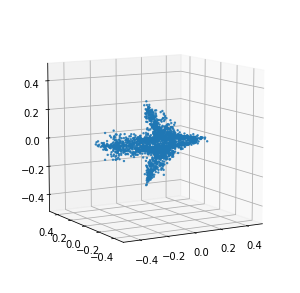

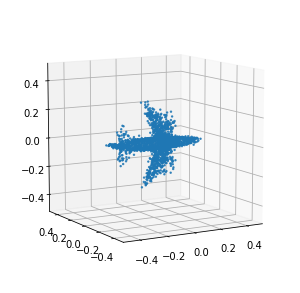

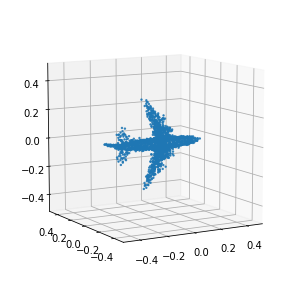

51 (-2.793589704686945, -4.444463643160733)
52 (-2.715897239338268, -4.247830781069669)
53 (-2.65988825451244, -4.283236070112749)
54 (-2.5919069723649457, -4.030153101140803)
55 (-2.505802462317727, -3.678242965178056)
56 (-2.44775407964533, -3.529409083453092)
57 (-2.404853695089167, -3.5080994042483242)
58 (-2.340810441970825, -3.2333968552676113)
59 (-2.295979694886641, -3.0213604406876997)
60 (-2.2611697327006945, -2.8230547471479936)
61 (-2.207847898656672, -2.5206050005826084)
62 (-2.1994074929844247, -2.573493393984708)
63 (-2.1395732229406184, -2.3734552426771685)
64 (-2.1137362350117077, -2.249283855611628)
65 (-2.1065775567835026, -2.003110874782909)
66 (-2.0712396708401766, -1.8751241402192549)
67 (-2.043604751066728, -2.012137629769065)
68 (-2.015306275541132, -1.715431733564897)
69 (-1.9957747351039539, -1.6078911477869207)
70 (-1.9841697172685102, -1.4787706245075574)
71 (-1.9557785879481921, -1.3549370115453547)
72 (-1.9457683476534757, -1.4527157111601396)
73 (-1.94378

227 (-0.9719169833443382, -0.3042346090078354)
228 (-0.9547202684662559, -0.24506214396520096)
229 (-0.9699459736997431, -0.22693117233839902)
230 (-0.9675228660756892, -0.2127343538132581)
231 (-0.9651028568094427, -0.15313519063321027)
232 (-0.9677137775854631, -0.11252748221158981)
233 (-0.9580709305676547, -0.1670296381820332)
234 (-0.9698534802957015, -0.13363832760263572)
235 (-0.9579878828742288, -0.2021613700146025)
236 (-0.9684258060021834, -0.22728319466114044)
237 (-0.9749358838254755, -0.2981111596931111)
238 (-0.9680165334181352, -0.2210340662436052)
239 (-0.9698938684030013, -0.3143642775037072)
240 (-0.9706937085498463, -0.28431057117202063)
241 (-0.9702105749737132, -0.20858056775548242)
242 (-0.9627836140719327, -0.30718440223823895)
243 (-0.9547731963070956, -0.3111892613497647)
244 (-0.9857479301365939, -0.3953638185154308)
245 (-0.9463869799267162, -0.4004837843504819)
246 (-0.9753593997521834, -0.45461631363088434)
247 (-0.9664419466798956, -0.3927915638143366)
248

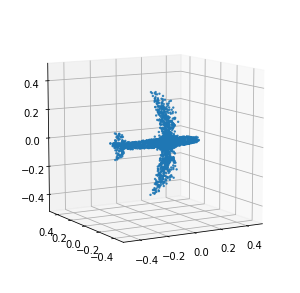

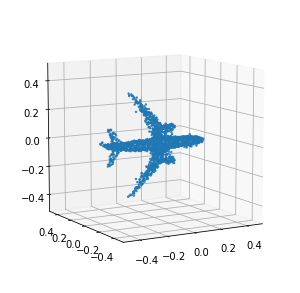

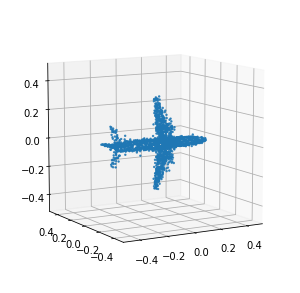

301 (-0.9254878423430702, -0.7656217217445374)
302 (-0.9408908139575611, -0.8456109274517406)
303 (-0.9542949990792708, -0.7626683766191656)
304 (-0.9304029356349598, -0.7880743362686851)
305 (-0.9512882969596169, -0.796305851502852)
306 (-0.9467240181836215, -0.6833112185651605)
307 (-0.9237087856639515, -0.6912469105287031)
308 (-0.945605900070884, -0.7366238019683145)
309 (-0.9243011171167547, -0.763819082216783)
310 (-0.9498017582026395, -0.7843373634598472)
311 (-0.9376035690307617, -0.7494926181706515)
312 (-0.9140676888552579, -0.8405199376019564)
313 (-0.9424745668064464, -0.8251062739979137)
314 (-0.9310252059589733, -0.8339679024436257)
315 (-0.9382668072527105, -0.7323396747762506)
316 (-0.9282942490144209, -0.7040841525251215)
317 (-0.9220800096338445, -0.6898188563910398)
318 (-0.9431929978457364, -0.6834991249171171)
319 (-0.9381958452138034, -0.767898288640109)
320 (-0.9429512338204817, -0.8091966672377153)
321 (-0.9207299221645702, -0.8150754516774957)
322 (-0.910377257

478 (-0.9046040285717357, -0.6066182418303057)
479 (-0.8963336185975508, -0.5915621573274786)
480 (-0.8895771438425237, -0.625681151043285)
481 (-0.8931544780731201, -0.6075091632929716)
482 (-0.9096842830831354, -0.5884003666314211)
483 (-0.8973424889824607, -0.5994679711081765)
484 (-0.9077363599430431, -0.6020132465796038)
485 (-0.9065973411906849, -0.5714783018285577)
486 (-0.883792058988051, -0.5647871413014152)
487 (-0.9034239909865639, -0.5667702989144758)
488 (-0.8990151318636808, -0.5791566209359602)
489 (-0.8940819458527999, -0.5734324780377474)
490 (-0.8828890724615617, -0.6051324660127814)
491 (-0.884392232244665, -0.5980087247761813)
492 (-0.8971696918660944, -0.6006329222158953)
493 (-0.8926360552961176, -0.5576053911989386)
494 (-0.8994708624753085, -0.5561132593588396)
495 (-0.8835103305903348, -0.5520273636687886)
496 (-0.8894634225151755, -0.5621063194491647)
497 (-0.9019634918733077, -0.5785843621600758)
498 (-0.8781194361773405, -0.5860352218151093)
499 (-0.89035946

In [13]:
# Train the GAN.
for _ in range(n_epochs):
    loss, duration = gan._single_epoch_train(latent_data, batch_size, noise_params)
    epoch = int(gan.sess.run(gan.increment_epoch))
    print epoch, loss

    if save_gan_model and epoch in saver_step:
        checkpoint_path = osp.join(train_dir, MODEL_SAVER_ID)
        gan.saver.save(gan.sess, checkpoint_path, global_step=gan.epoch)

    if save_synthetic_samples and epoch in saver_step:
        syn_latent_data = gan.generate(n_syn_samples, noise_params)
        syn_data = ae.decode(syn_latent_data)
        np.savez(osp.join(synthetic_data_out_dir, 'epoch_' + str(epoch)), syn_data)
        for k in range(3):  # plot three (syntetic) random examples.
            plot_3d_point_cloud(syn_data[k][:, 0], syn_data[k][:, 1], syn_data[k][:, 2],
                               in_u_sphere=True)

    train_stats.append((epoch, ) + loss)

/home/gy46/anaconda3/envs/tfpy2.7/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


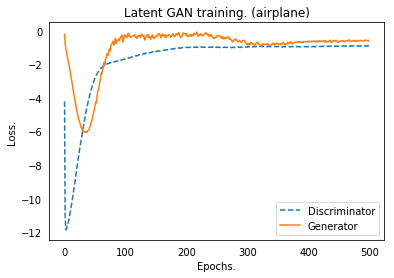

In [14]:
# if plot_train_curve:
x = range(len(train_stats))
d_loss = [t[1] for t in train_stats]
g_loss = [t[2] for t in train_stats]
plt.plot(x, d_loss, '--')
plt.plot(x, g_loss)
plt.title('Latent GAN training. (%s)' %(class_name))
plt.legend(['Discriminator', 'Generator'], loc=0)

plt.tick_params(axis='x', which='both', bottom='off', top='off')
plt.tick_params(axis='y', which='both', left='off', right='off')

plt.xlabel('Epochs.') 
plt.ylabel('Loss.')
plt.show()

# Evaluation

In [15]:
from latent_3d_points.src.evaluation_metrics import minimum_mathing_distance as MMD
from latent_3d_points.src.evaluation_metrics import jsd_between_point_cloud_sets as JSD
from latent_3d_points.src.evaluation_metrics import coverage as COV


In [16]:
# top_in_dir = '../data/shape_net_core_uniform_samples_2048/' # Top-dir of where point-clouds are stored.
top_in_dir = '../data/ShapeNetV1PCOutput/' # Top-dir of where point-clouds are stored.
syn_id = snc_category_to_synth_id()[class_name]
class_dir = osp.join(top_in_dir , syn_id, 'val')
# all_pc_data = load_all_point_clouds_under_folder(class_dir, n_threads=8, file_ending='.ply', verbose=True)
all_pc_data = load_all_point_clouds_under_folder(class_dir, n_threads=8, file_ending='.npy', verbose=True)



405 pclouds were loaded. They belong in 1 shape-classes.


In [17]:
feed_pc, _, _ = all_pc_data.full_epoch_data()
feed_pc_tr = feed_pc[:, :n_pc_points]
feed_pc_te = feed_pc[:, -n_pc_points:]
feed_pc_tr.shape, feed_pc_te.shape

((405, 2048, 3), (405, 2048, 3))

In [18]:
syn_latent_data = gan.generate(feed_pc_tr.shape[0], noise_params)
syn_data = ae.decode(syn_latent_data)

syn_latent_data.shape, syn_data.shape

((405, 128), (405, 2048, 3))

In [19]:
mmd_emd, _ = MMD(syn_data, feed_pc_te, 200, use_EMD=True, verbose=True)
mmd_emd

0
50
100
150
200
250
300
350
400


0.036201224

In [20]:
mmd_cd, _ = MMD(syn_data, feed_pc_te, 200, use_EMD=False, verbose=True)
mmd_cd

0
50
100
150
200
250
300
350
400


0.00020387393

In [21]:
cov_emd, _ = COV(syn_data, feed_pc_te, 200, use_EMD=True, verbose=True)
cov_emd

0
50
100
150
200
250
300
350
400


0.16049382716049382

In [22]:
cov_cd, _ = COV(syn_data, feed_pc_te, 200, use_EMD=False, verbose=True)
cov_cd

0
50
100
150
200
250
300
350
400


0.37037037037037035

In [23]:
jsd = JSD(syn_data, feed_pc_te)
jsd

0.09791479043802553